In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader 
import pathlib
import glob
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import flatten

In [2]:
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/nature_12K.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/nature') #Extracts the files into the /nature folder
zip_ref.close()

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:


from torch.utils.data.sampler import SubsetRandomSampler

# how many samples per batch to load
batch_size =128
# percentage of training set to use as validation
valid_size = 0.2

#To unzip dataset in colab
data_dir='/nature/inaturalist_12K'

train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomAffine(degrees=0,scale=(0.3,1)),
                                       transforms.ToTensor(),
                                       
                                       transforms.Normalize([0.5,0.5, 0.5],
                                                            [0.5,0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      # transforms.RandomResizedCrop(224),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,0.5,0.5],
                                                           [0.5,0.5,0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = torchvision.datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(data_dir + '/val', transform=test_transforms)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]   ################<-------------------

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
print(len(train_sampler))
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler,num_workers=2)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
train_step=len(train_loader) ### this will return total data in train_sampler//batch_size(8000/128=63)
val_step=len(valid_loader)
print(train_step,val_step)

8000
63 16


In [7]:
# transformer=transforms.Compose([transforms.Resize((150,150)),transforms.RandomHorizontalFlip(),transforms.RandomRotation((-90,90)),transforms.RandomAffine(degrees=0,scale=(0.3,0.3)),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
                            


In [8]:
# batch=256
# #dataloader
train_path='/nature/inaturalist_12K/train'
test_path='/nature/inaturalist_12K/val'
# train_loader=DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer),
#                         batch_size=batch,shuffle=True)
# test_loader=DataLoader(torchvision.datasets.ImageFolder(test_path,transform=transformer),
#                         batch_size=batch,shuffle=True)


In [9]:
print(len(train_loader))

63


In [10]:
# # X,Y=train_loader[0]
# dataiter = iter(train_loader)
# images, labels = dataiter.next() 
# print(labels[0])

In [11]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [12]:
classes=(classes[1:])

In [13]:
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [14]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
train_count=int(train_count-train_count*0.2)  #################<----------------
test_count=len(glob.glob(test_path+'/**/*.jpg'))
val_count=int(train_count*0.2)

In [15]:
print(train_count,test_count)

7999 2000


In [16]:
# K=32
# S=3
# batch_norm=True
# activation='Relu'
# nodes=512
class ConvNet(nn.Module):
  def __init__(self,K,S,factor,activation,batch_norm,drop_out,nodes,num_class=10):
    
    super(ConvNet,self).__init__()
    
    self.batch_norm=batch_norm
    
    self.conv1=nn.Conv2d(in_channels=3,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,200,200)
    
    if self.batch_norm=='Yes':
      self.bn1=nn.BatchNorm2d(K)
      
    if activation=='Relu':
      
      self.activ1=nn.ReLU()
    elif activation=='Gelu':
    
      self.activ1=nn.GELU()
    elif activation=='Silu':
      
      self.activ1=nn.SiLU()
    elif activation=='Mish':
      
      self.activ1=nn.Mish()
      
    self.maxpool1=nn.MaxPool2d(kernel_size=2)## shape=(256,K,100,100)
    
    K_prev=K
    K=int(K*factor)
    #layer 2
    self.conv2=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,100,100)
    if self.batch_norm=='Yes':
      self.bn2=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ2=nn.ReLU()
    elif activation=='Gelu':
      self.activ2=nn.GELU()
    elif activation=='Silu':
      self.activ2=nn.SiLU()
    elif activation=='Mish':
      self.activ2=nn.Mish()
    self.maxpool2=nn.MaxPool2d(kernel_size=2)
    ##shape=(256,K,50,50)
    K_prev=K
    K=int(K*factor)
    # layer 3
    self.conv3=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,50,50)
    if self.batch_norm=='Yes':
      self.bn3=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ3=nn.ReLU()
    elif activation=='Gelu':
      self.activ3=nn.GELU()
    elif activation=='Silu':
      self.activ3=nn.SiLU()
    elif activation=='Mish':
      self.activ3=nn.Mish()
    self.maxpool3=nn.MaxPool2d(kernel_size=2)
    ##shape=(256,K,25,25)
    K_prev=K
    K=int(K*factor)
    #layer 4
    self.conv4=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,25,25)
    if self.batch_norm=='Yes':
      self.bn4=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ4=nn.ReLU()
    elif activation=='Gelu':
      self.activ4=nn.GELU()
    elif activation=='Silu':
      self.activ4=nn.SiLU()
    elif activation=='Mish':
      self.activ4=nn.Mish()
    self.maxpool4=nn.MaxPool2d(kernel_size=2)
    ## shape=(256,K,12,12)
    K_prev=K
    K=int(K*factor)
    #layer 5
    self.conv5=nn.Conv2d(in_channels=K_prev,out_channels=K,kernel_size=S,stride=1,padding=(S-1)//2) #its output size will be=(batch=256,K,12,12)
    if self.batch_norm=='Yes':
      self.bn5=nn.BatchNorm2d(K)
    if activation=='Relu':
      self.activ5=nn.ReLU()
    elif activation=='Gelu':
      self.activ5=nn.GELU()
    elif activation=='Silu':
      self.activ5=nn.SiLU()
    elif activation=='Mish':
      self.activ5=nn.Mish()
    self.maxpool5=nn.MaxPool2d(kernel_size=2)
    ## shape(256,K,6,6)
    #print(len(self.maxpool5))
     ## shape(256,K,)
    ## FC layer
    # self.dropout1=nn.Dropout(drop_out)            ### ADD DROPOUT HERE
    #print("D:",self.dropout1.shape)
    self.fc1=nn.Linear(in_features=7*7*K,out_features=nodes)
    self.dropout2=nn.Dropout(drop_out)   ### ADD DROP OUT HERE
    self.fc2=nn.Linear(in_features=nodes,out_features=10)
    
    ##feed forward

  def forward(self,x):
    
    out=self.conv1(x)
    if self.batch_norm=='Yes':
      out=self.bn1(out)
    out=self.activ1(out)
    out=self.maxpool1(out)

    out=self.conv2(out)
    if self.batch_norm=='Yes':
      out=self.bn2(out)
    out=self.activ2(out)
    out=self.maxpool2(out)

    out=self.conv3(out)
    if self.batch_norm=='Yes':
      out=self.bn3(out)
    out=self.activ3(out)
    out=self.maxpool3(out)

    out=self.conv4(out)
    if self.batch_norm=='Yes':
      out=self.bn4(out)
    out=self.activ4(out)
    out=self.maxpool4(out)
    
    out=self.conv5(out)
    if self.batch_norm=='Yes':
      out=self.bn5(out)
    out=self.activ5(out)
    out=self.maxpool5(out)
    
    # out=self.dropout1(out)
    b,c,d,e=out.shape
  
    out=out.view(-1,d*e*c)  
    
    out=F.relu(self.fc1(out))
    out=self.dropout2(out)
    out=F.relu(self.fc2(out))
    out=F.softmax(out,dim=1)
    
    return out


# K,S,factor,activation,batch_norm,drop_out,nodes=64,3,1,'Gelu','No',0.3,256
# net=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes,num_class=10)
# print(net)

In [17]:
# model=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes,num_class=10).to(device)

In [18]:
# import torch.optim as optim

# optimizer=optim.Adam(model.parameters(),lr=0.0002)
# loss_fun=nn.CrossEntropyLoss()



In [19]:
# from torch.autograd import Variable
# ##model training

# best_accuracy=0

# for epoch in range(30):

#   model.train()
#   train_accuracy=0.0
#   train_loss=0.0
#   for i,(images,labels) in enumerate(train_loader):
    
    
#     images=images.to(device)
#     labels=labels.to(device)
    
#     optimizer.zero_grad()
    
#     outputs=model(images)
#     loss=loss_fun(outputs,labels)
#     # print(loss.dtype)
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     #print(loss.cpu().data)
#     train_loss+=(loss.item())/batch_size
#     #print(loss.item())
#     _,prediction=torch.max(outputs.data,1)
    
#     train_accuracy+=int(torch.sum(prediction==labels.data))
#   train_accuracy=(train_accuracy/(batch_size*train_step))*100
#   train_loss=(train_loss/train_step)*100
#   print(train_loss)

#   ##evalution on testing data
#   model.eval()
#   with torch.no_grad():
#     test_accuracy=0.0

#     for i,(images,labels) in enumerate(valid_loader):
    
#       images=images.to(device)
#       labels=labels.to(device)
      
#       outputs=model(images)

#       _,prediction=torch.max(outputs.data,1)
#       test_accuracy+=int(torch.sum(prediction==labels.data))
  
#   test_accuracy=(test_accuracy/(batch_size*val_step))*100


#   print('Epoch:'+str(epoch)+' Train Loss:'+str(float(train_loss))+' Train accuracy'+str(train_accuracy)+' valaccuracy'+str(test_accuracy))
  
#   # if test_accuracy>best_accuracy:
#   #   torch.save(model.state_dict(),'best_checkpoint.model')
#   #   best_accuracy=test_accuracy


In [17]:
 !pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=4b346a04d952e86b39f9a768d94f5282349b64a2e0fa18496e2ebb8693d2278d
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [21]:
# install,login and import wandb

In [18]:
import wandb

In [19]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 7z63jlgr
Sweep URL: https://wandb.ai/amanvb-9213/DL-assignment2/sweeps/7z63jlgr


wandb: Agent Starting Run: u4t2erue with config:
wandb: 	activation: Silu
wandb: 	batch_norm: No
wandb: 	drop_out: 0.3
wandb: 	filter_n: 64
wandb: 	filter_org: 1
wandb: Currently logged in as: amanvb-9213. Use `wandb login --relogin` to force relogin


run_name: Fn_64_Fo_1_acf_Silu_bn_No_Do_0.3
max__train_accuracy: 30.567956349206348
max__validation_accuracy: 28.759765625
min_train_loss: 1.6724701320368147
min_validation_loss: 1.686031254939735


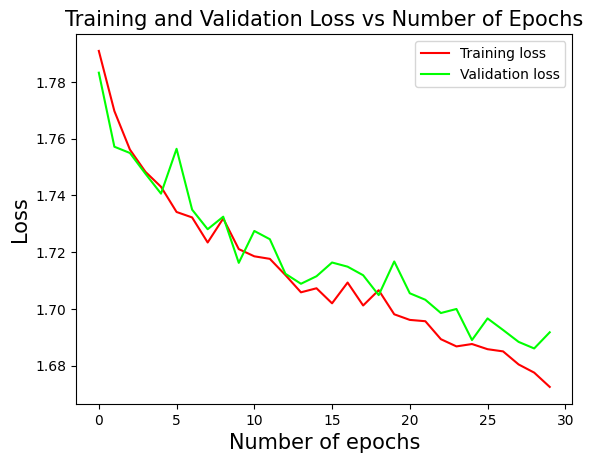

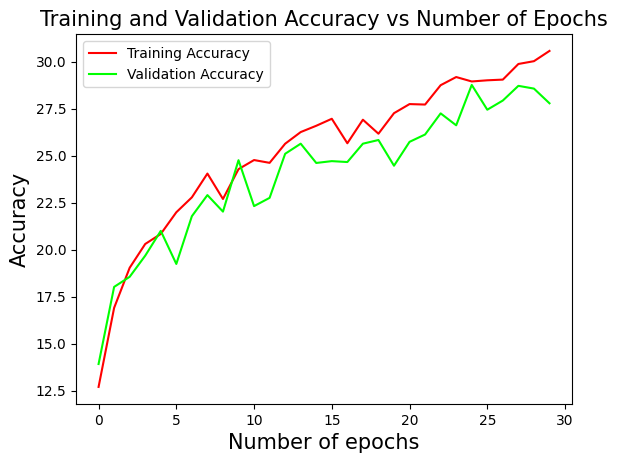

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


train_acc,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇███
train_loss,█▇▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
val_acc,▁▃▃▄▄▄▅▅▅▆▅▅▆▇▆▆▆▇▇▆▇▇▇▇█▇████
val_loss,█▆▆▅▅▆▅▄▄▃▄▄▃▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁
train_acc,30.56796
train_loss,1.67247
val_acc,27.7832
val_loss,1.69173


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7s7d4nvx with config:
wandb: 	activation: Mish
wandb: 	batch_norm: No
wandb: 	drop_out: 0.2
wandb: 	filter_n: 64
wandb: 	filter_org: 2


run_name: Fn_64_Fo_2_acf_Mish_bn_No_Do_0.2
max__train_accuracy: 19.655257936507937
max__validation_accuracy: 19.82421875
min_train_loss: 1.7568379670145022
min_validation_loss: 1.7536805011332035


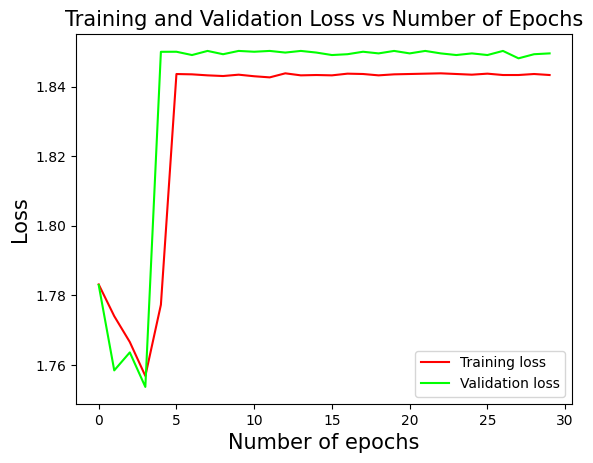

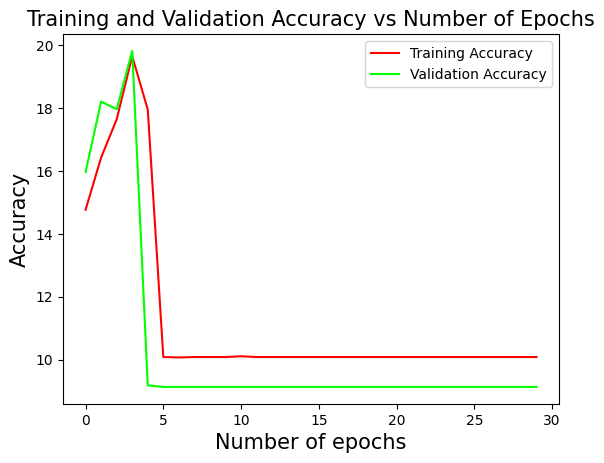

train_acc,▄▆▇█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▃▂▂▁▃█████████████████████████
val_acc,▅▇▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▁▂▁██████████████████████████
train_acc,10.08185
train_loss,1.84333
val_acc,9.13086
val_loss,1.84955


wandb: Agent Starting Run: i3u5bmx8 with config:
wandb: 	activation: Gelu
wandb: 	batch_norm: No
wandb: 	drop_out: 0.3
wandb: 	filter_n: 32
wandb: 	filter_org: 1


run_name: Fn_32_Fo_1_acf_Gelu_bn_No_Do_0.3


In [ ]:
sweep_configuration={'name':'EE22s037','method':'bayes',
                      'metric':{'name':'val_acc','goal':'maximize'},
                      'parameters':{#'epoch':{'values':[15,30]},
                                    # 'lr':{'values':[0.01,0.001,0.0005]},
                                    'filter_n':{'values':[32,64]},
                                    # 'filter_size':{'values':[3]},
                                    'filter_org':{'values':[1,2,0.5]},
                                    'activation':{'values':['Relu','Gelu','Silu','Mish']},
                                    'batch_norm':{'values':['Yes','No']},
                                    'drop_out':{'values':[0.2,0.3]}
                                    #'neurons':{'values':[128,256,512]}                   
                                   }
                    
                      
                      }



def train():
  wandb.init()
  # epoch=wandb.config.epoch
  #lr=wandb.config.lr
  K=wandb.config.filter_n
  #S=wandb.config.filter_size
  factor=wandb.config.filter_org
  activation=wandb.config.activation
  batch_norm=wandb.config.batch_norm
  drop_out=wandb.config.drop_out
  #nodes=wandb.config.neurons
  S=3  ## filter_size
  run_name="Fn_{}_Fo_{}_acf_{}_bn_{}_Do_{}".format(K,factor,activation,batch_norm,drop_out)
  print("run_name:",run_name)
  
  model=ConvNet(K,S,factor,activation,batch_norm,drop_out,nodes=256,num_class=10).to(device)
  
  optimizer=optim.Adam(model.parameters(),lr=0.0003)
  loss_fun=nn.CrossEntropyLoss()
  best_accuracy=0
  train_Loss=[]
  train_Acc=[]
  val_Loss=[]
  val_Acc=[]
  for e in range(30):
    
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    for i,(images,labels) in enumerate(train_loader):
      
      
      images=images.to(device)
      labels=labels.to(device)

      optimizer.zero_grad()
      outputs=model(images)
      
      loss=loss_fun(outputs,labels)
      
    #print(loss)
      loss.backward()
      optimizer.step()
      train_loss+=(loss.item())/batch_size
    #print(loss.cpu().data)
      # train_loss+=loss.cpu().data*images.size(0)
      scores,prediction=torch.max(outputs.data,1)

      train_accuracy+=int(torch.sum(prediction==labels.data))
    train_accuracy=(train_accuracy/(train_step*batch_size))*100
    train_Acc.append(train_accuracy)
    train_loss=(train_loss/train_step)*100
    train_Loss.append(train_loss)

    ##evalution on testing data
    model.eval()
    with torch.no_grad():
      val_accuracy=0.0
      val_loss=0
      for i,(images,labels) in enumerate(valid_loader):
        # if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
        
        outputs=model(images)
        loss=loss_fun(outputs,labels)
        val_loss+=(loss.item())/batch_size
        scores,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
    
      val_accuracy=(val_accuracy/(val_step*batch_size))*100
      val_Acc.append(val_accuracy)
      val_loss=(val_loss/val_step)*100
      val_Loss.append(val_loss)
    
    wandb.log({#'epoch':e,
               'train_acc':train_accuracy,
               'train_loss':train_loss,
               'val_acc': val_accuracy,
               'val_loss':val_loss       
              })

  ### print and ploting loss and accuracy here
  print("max__train_accuracy:",np.max(train_Acc),)
  print("max__validation_accuracy:",np.max(val_Acc))
  print("min_train_loss:",np.min(train_Loss))
  print("min_validation_loss:",np.min(val_Loss))
  plt.plot(train_Loss, 'r', label="Training loss")
  plt.plot(val_Loss, 'lime', label="Validation loss")
  plt.title("Training and Validation Loss vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Loss", size=15)
  plt.legend()
  plt.show()

  
  plt.plot(train_Acc, 'r', label="Training Accuracy")
  plt.plot(val_Acc ,'lime', label="Validation Accuracy")
  plt.title("Training and Validation Accuracy vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Accuracy", size=15)
  plt.legend()
  plt.show()   
  wandb.run.name = run_name
  wandb.run.save()
  wandb.run.finish()
    # print('Epoch:'+str(epoch)+'Train Loss:'+str(int(train_loss))+'Train accuracy'+str(train_accuracy)+'Test accuracy'+str(test_accuracy))
  
    # if test_accuracy>best_accuracy:
    #   torch.save(model.state_dict(),'best_checkpoint.model')
    #   best_accuracy=test_accuracy


sweep_id="7z63jlgr"
wandb.agent(sweep_id,function=train,entity="amanvb-9213",project='DL-assignment2')
 





  

 
